In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import math
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import preprocessing
import wheat_mlr as wht
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from scipy.signal import savgol_filter
import warnings

In [29]:
def scale_variable(x_train, x_test):
    std_scale = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled, x_test_scaled = std_scale.transform(x_train), std_scale.transform(x_test)
    return x_train_scaled, x_test_scaled

def pcaMLR(df_spectres, df_containment):
    MSE, R2_value = {}, {}
    x_train_for_scale, x_test_for_scale = df_spectres.iloc[0:len(df_spectres):2, :], df_spectres.iloc[1:len(df_spectres):2, :]
    x_train, x_test = scale_variable(x_train_for_scale, x_test_for_scale)
    train_test_dict = {
        'Влага': wht.getTrainData(df_containment, 'Влага'),
        'Клейковина': wht.getTrainData(df_containment, 'Клейковина'),
        'Зольность': wht.getTrainData(df_containment, 'Зольность')
    }
    pca_lr = PCA()
    reduce_train, reduce_test = pca_lr.fit_transform(preprocessing.scale(x_train)), pca_lr.fit_transform(preprocessing.scale(x_test))
    variance_explained = np.cumsum(np.round(pca_lr.explained_variance_ratio_, decimals=4)*100)
    print(variance_explained)
    for key, value in train_test_dict.items():
        regression = LinearRegression()
        regression.fit(x_train, value[0])
        predicted_results = regression.predict(x_test)
        MSE[key] = mean_squared_error(value[1], predicted_results)
        R2_value[key] = r2_score(value[1], predicted_results)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111)
        axis_x = range(1,8)
        ax.plot(axis_x, [point_y for point_y in predicted_results], color='red', label='Спрогнозированные данные')
        ax.plot(axis_x, [point_y for point_y in value[1]], color='blue', label='Актуальные данные')
        ax.scatter(axis_x, predicted_results, color='red')
        ax.scatter(axis_x, value[1], color='blue')
        plt.legend(loc='upper left')
        plt.xticks([i for i in axis_x])
        plt.xlabel('Номер измерения')
        plt.ylabel('Содержание ' + key.lower())
        plt.show()
        print('MSE', MSE)
        print('R2_value', R2_value)
#     pca_lr_2 = PCA()
#     reduced_train_test = pca_lr_2.fit_transform(preprocessing.scale(df_spectres))
#     reg = LinearRegression()
#     print(df_containment['Влага'].shape)
#     reg.fit(reduced_train_test, df_containment['Влага'])
#     y_predict = reg.predict(reduced_train_test)
#     R2_value = r2_score(df_containment['Влага'], y_predict)
#     print(R2_value)

In [30]:
def accomplishPCR(df_spectres, df_containment):
    data_spec_containment = pd.concat([df_spectres, df_containment], axis=1, join='inner')
    pca = PCA()
    data_scaled = pca.fit_transform(preprocessing.scale(data_spec_containment))
    variance_explained = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#     print(variance_explained)
    epochs = len(data_scaled)
#     print('epochs', epochs)
    crossval = model_selection.KFold(n_splits=10, shuffle=True, random_state=2)
    regression = LinearRegression()
    mse = []
    for i in np.arange(1,6):
        score = -1*model_selection.cross_val_score(regression, data_scaled[:,:i], df_containment, cv=crossval, scoring='neg_mean_squared_error').mean()
        mse.append(score)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    ax1.plot(mse, '-k')
    ax2.plot([1,2,3,4,5], mse[0:6], '-r')
    ax2.set_title('')
    for ax in fig.axes:
        ax.set_xlabel('Количество главных компонент в регрессии')
        ax.set_ylabel('СКО')
#         ax.set_xlim((-0.2,5.2)) \
    plt.show()
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    pca_df = pd.DataFrame(data_scaled, columns=labels)
    plt.scatter(pca_df.PC1, pca_df.PC2)
    plt.title('PCA')
    plt.xlabel('ГК1 - {0}%'.format(per_var[0]))
    plt.ylabel('ГК2 - {0}%'.format(per_var[1]))
    plt.show()
    return data_spec_containment

In [162]:
def plsModel(x_train, x_test, n_comp, y_train, y_test):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(preprocessing.scale(x_train), y_train)
    MSE = mean_squared_error(y_test, pls.predict(preprocessing.scale(x_test)))
    R2_value = r2_score(y_test,  pls.predict(preprocessing.scale(x_test)))
    print(MSE, R2_value)

def accomplishPLS(df_spectres, df_containment):
    MSE, R2_value = {}, {}
    x_train, x_test = savgol_filter(df_spectres.iloc[0:len(df_spectres):2, :], 11, polyorder=2, deriv=1), savgol_filter(df_spectres.iloc[1:len(df_spectres):2, :], 13, polyorder=2, deriv=2)
    train_test_dict = {
        'Влага': wht.getTrainData(df_containment, 'Влага'),
        'Клейковина': wht.getTrainData(df_containment, 'Клейковина'),
        'Зольность': wht.getTrainData(df_containment, 'Зольность')
    }
    kf_10 = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)

    mse = []

    for i in np.arange(1, 20):
        pls = PLSRegression(n_components=i)
        score = model_selection.cross_val_score(pls, preprocessing.scale(x_train), train_test_dict['Зольность'][0], cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)

    # Plot results
    plt.plot(np.arange(1, 20), np.array(mse), '-v')
    plt.xlabel('Количество главных компонент в выборке')
    plt.ylabel('СКО')
    plt.xlim(0, 20, 1)
    plt.xticks([i for i in range(1,20)])
    
    plsModel(x_train, x_test, 3, train_test_dict['Влага'][0], train_test_dict['Влага'][1])
    plsModel(x_train, x_test, 3, train_test_dict['Клейковина'][0], train_test_dict['Клейковина'][1])
    plsModel(x_train, x_test, 3, train_test_dict['Зольность'][0], train_test_dict['Зольность'][1])
#     for key, value in train_test_dict.items():
#         pls = PLSRegression(n_components=5)
#         pls.fit(preprocessing.scale(x_train), value[0])
#         MSE[key] = mean_squared_error(value[1], pls.predict(preprocessing.scale(x_test)))
#         R2_value[key] = r2_score(value[1],  pls.predict(preprocessing.scale(x_test)))
#     print(MSE, R2_value)

In [166]:
def plsbigdata(df_x_train, df_y_train, df_x_test, df_y_test):
    MSE, R2_value = {}, {}
    x_train, x_test = savgol_filter(df_x_train, 11, polyorder=2, deriv=1), savgol_filter(df_x_test, 13, polyorder=2, deriv=2)
    y_train, y_test = df_y_train, df_y_test
    kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    train_test_dict = {
        'Влага': (y_train['Влага'], y_test['Влага']),
        'Клейковина': (y_train['Клейковина'], y_test['Клейковина']),
        'Зольность': (y_train['Зольность'], y_test['Зольность'])
    }
    mse = []

    for i in np.arange(1, 20):
        pls = PLSRegression(n_components=i)
        score = model_selection.cross_val_score(pls, preprocessing.scale(x_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)

    # Plot results
    plt.figure()
    plt.plot(np.arange(1, 20), np.array(mse), '-v')
    plt.xlabel('Количество главных компонент в выборке')
    plt.ylabel('СКО')
    plt.xlim(0, 20, 1)
    plt.xticks([i for i in range(1,20)])
    
    for key, value in train_test_dict.items():
        pls = PLSRegression(n_components=3)
        pls.fit(preprocessing.scale(x_train),value[0])
        MSE[key] = mean_squared_error(value[1], pls.predict(preprocessing.scale(x_test)))
        R2_value[key] = r2_score(value[1],  pls.predict(preprocessing.scale(x_test)))
    print('BIG DATA', MSE, R2_value)

In [185]:
def pls_optimization(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = model_selection.cross_val_predict(pls, X, y, cv=7)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/40
        # Trick to update status on the same line

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = model_selection.cross_val_predict(pls_opt, X, y, cv=7)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$: '+str(score_c))
        plt.xlabel('Предсказанное значение')
        plt.ylabel('Фактическое значение')

        plt.show()

    return

In [192]:
def main():
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
    cwd = os.getcwd()
    cwd_wheat = "C:/Users/Alexander/Desktop/диплом"
    os.chdir(cwd_wheat)
    file_name_df = "Ставр_данные.xlsx"
    df_spectres, df_containment = wht.createDataframes(file_name_df)
    accomplishPCR(df_spectres, df_containment)
    pcaMLR(df_spectres, df_containment)
    accomplishPLS(df_spectres, df_containment)
    y_train_moist, y_test_moist = wht.getTrainData(df_containment, 'Влага')
    y_train_gluten, y_test_gluten = wht.getTrainData(df_containment, 'Клейковина')
    y_train_ash, y_test_ash = wht.getTrainData(df_containment, 'Зольность')
    file_name_df_test = "Краснодар_данные.xlsx"
    df_specs_test, df_containment_test = wht.createDataframes(file_name_df_test)
    plsbigdata(df_spectres, df_containment, df_specs_test, df_containment_test)
    x_test = savgol_filter(df_spectres.iloc[0:len(df_spectres):2, :], 11, polyorder=2, deriv=1)
    pls_optimization(x_test, y_train_moist, 7, plot_components=True)
    pls_optimization(x_test, y_train_gluten, 7, plot_components=True)
    pls_optimization(x_test, y_train_ash, 7, plot_components=True)
    
#     optimise_pls_cv(df_spectres.iloc[0:len(df_spectres):2, :], y_train, 40, plot_components=True)
    
#     print(df_spectres, '\n', df_containment)

[[0.37099838 0.37768234 0.38007229 ... 0.78701382 0.86518563 0.9625735 ]
 [0.31318505 0.31957383 0.32184596 ... 0.69637202 0.76802097 0.85667287]
 [0.36171046 0.36855623 0.37110044 ... 0.7780644  0.85604888 0.95428594]
 ...
 [0.38048928 0.38753404 0.39008559 ... 0.80134291 0.88074411 0.97922451]
 [0.37345434 0.38007229 0.38247547 ... 0.79263496 0.86966623 0.96497072]
 [0.39555793 0.40263395 0.40527605 ... 0.82073554 0.90031936 0.99913228]]


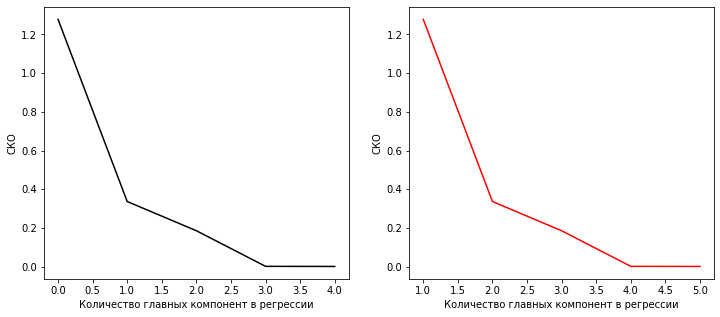

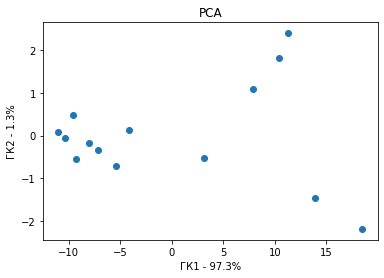

[99.93 99.98 99.99 99.99 99.99 99.99 99.99]


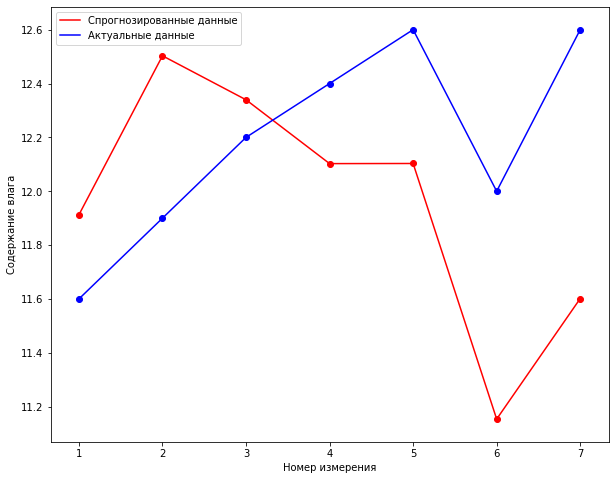

MSE {'Влага': 0.3613430618529754}
R2_value {'Влага': -1.9807760994605723}


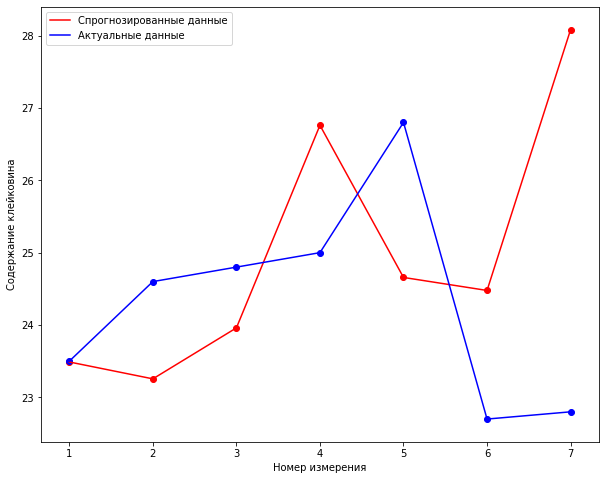

MSE {'Влага': 0.3613430618529754, 'Клейковина': 5.894904500521056}
R2_value {'Влага': -1.9807760994605723, 'Клейковина': -2.293618250006062}


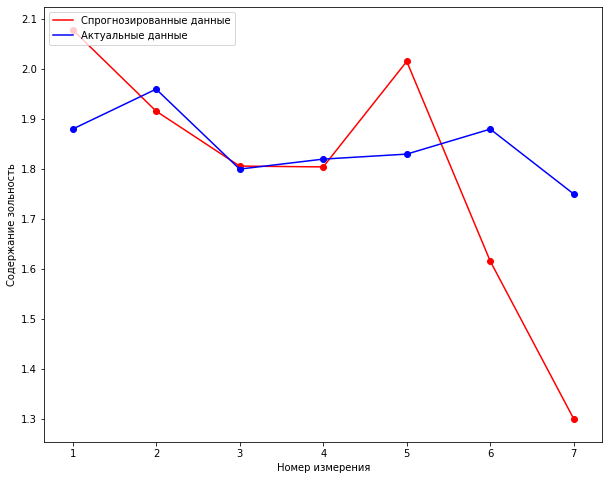

MSE {'Влага': 0.3613430618529754, 'Клейковина': 5.894904500521056, 'Зольность': 0.0498060975515484}
R2_value {'Влага': -1.9807760994605723, 'Клейковина': -2.293618250006062, 'Зольность': -11.645071399097795}
0.4419454261418799 -2.6456777577360477
1.4534523959668222 0.18792283463655346
0.005776288341101021 -0.4665188016266859
[[0.45529835 0.44913108 0.44686246 ... 0.19037296 0.16246522 0.12998257]
 [0.4963482  0.48973523 0.48730893 ... 0.21641369 0.18576972 0.15026558]
 [0.44953316 0.44320437 0.44097962 ... 0.18784833 0.16011111 0.12792651]
 ...
 [0.43581109 0.42961353 0.42732353 ... 0.18010548 0.15306939 0.1219869 ]
 [0.4332138  0.42673028 0.42443231 ... 0.17743444 0.150311   0.11920298]
 [0.43074434 0.42494385 0.42294041 ... 0.17581948 0.14988762 0.11990416]]
BIG DATA {'Влага': 0.15366938766489627, 'Клейковина': 2.214923790507487, 'Зольность': 0.004091720333713922} {'Влага': 0.3389113261123853, 'Клейковина': -0.10139299507678845, 'Зольность': -0.14682852196186058}
Suggested number of 

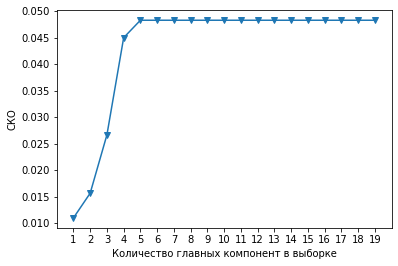

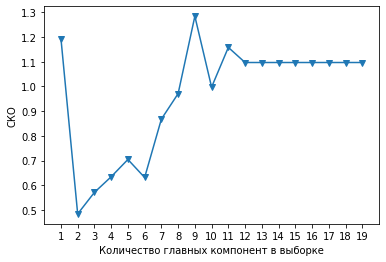

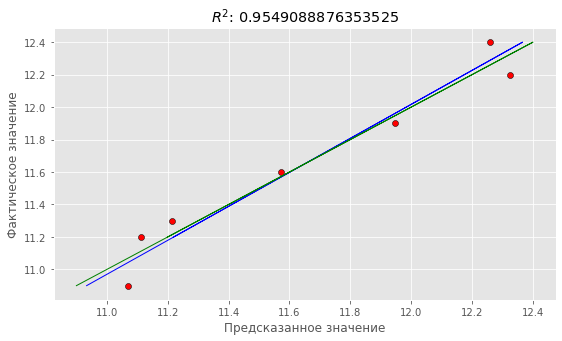

Suggested number of components:  2
R2 calib: 0.852
R2 CV: 0.492
MSE calib: 0.325
MSE CV: 1.115


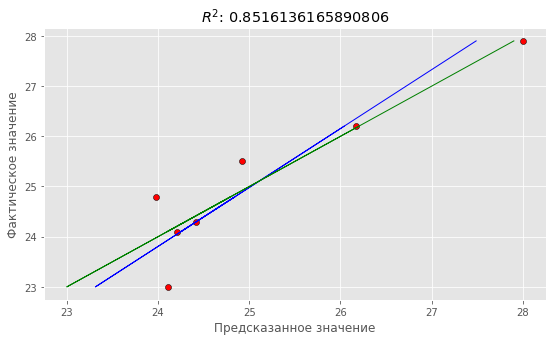

Suggested number of components:  1
R2 calib: 0.160
R2 CV: -1.815
MSE calib: 0.003
MSE CV: 0.010


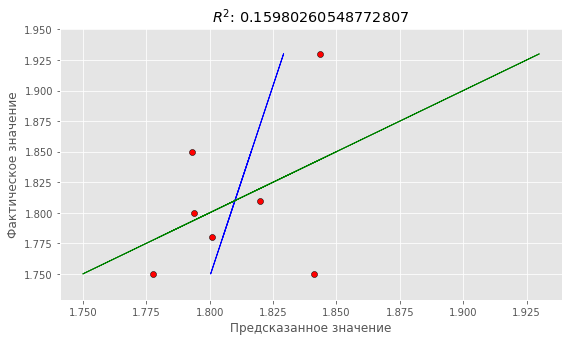

In [193]:
if __name__ == "__main__":
    main()